In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.linear_model import Lasso
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import time

In [3]:
import sys
sys.path.append('../')
import adaprobe

In [247]:
N = 64
a = 0.25
sigma = 1
K = 500
num_targets = 16
powers = np.arange(10, 51, 10)
# powers = np.array([60])

In [248]:
phi_1 = np.random.uniform(2.5, 5.5, N)
sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)
sim.simulate_multistim(trials=K, num_targets=np.min([num_targets, N]), powers=powers)

stimulus_matrix = np.zeros((N, K))
for n in range(N):
    locs = np.where(sim.tars == n)[0]
    stimulus_matrix[n, locs] = sim.I[locs]
bin_stimulus_matrix = stimulus_matrix.copy()
bin_stimulus_matrix[stimulus_matrix > 0] = 1

In [249]:
sparse_lasso = Lasso(alpha=1e-2, fit_intercept=False, max_iter=1000)
sparse_lasso.fit(bin_stimulus_matrix.T, sim.y)

Lasso(alpha=0.01, fit_intercept=False)

In [250]:
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 7e0 * np.ones(N)
mu_prior = np.zeros(N)

fit_options = {
    'iters': 100,
    'num_mc_samples': 20,
    'seed': 1
}

priors = {
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

model = adaprobe.Model(sim.cell_locs, priors=priors)
model.fit(sim.y, stimulus_matrix, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')


In [251]:
alpha = model.state['alpha']
beta = model.state['beta']
w_est = alpha * model.state['mu']

In [252]:
fontsize=12

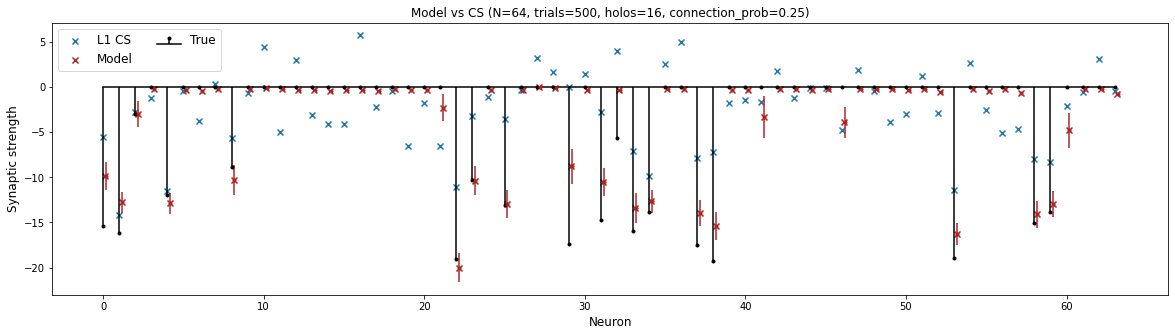

In [254]:
rng = np.arange(N)

plt.figure(figsize=(20, 5))
plt.stem(np.arange(N), sim.w, linefmt='k', markerfmt='k.', basefmt='k-', label='True')

# L1 CS
plt.scatter(rng, sparse_lasso.coef_, marker='x', color='C0', label='L1 CS')

# Model
model_offset = 0.15
plt.scatter(rng + model_offset, w_est, marker='x', color='firebrick', label='Model')
plt.errorbar(rng + model_offset + 0.03, w_est, yerr= beta * (alpha >= 0.5), fmt='.', color='firebrick')

plt.legend(fontsize=fontsize, frameon=True, ncol=2)
plt.ylabel('Synaptic strength', fontsize=fontsize)
plt.xlabel('Neuron', fontsize=fontsize)

plt.title('Model vs CS (N=%i, trials=%i, holos=%i, connection_prob=%.2f)'%(N, K, num_targets, a), fontsize=fontsize)
# plt.savefig('figs/compressed_sensing/low_trial_count_N%i_trials%i_holos%i_connection_prob%.2f.png'%(N, K, num_targets, a), format='png', dpi=200, bbox_inches='tight', facecolor='white')

plt.show()
